<a href="https://colab.research.google.com/github/Yug-Oswal/Custom-DistributedTraining-TF/blob/main/ObjectLocalization(FromScratch_On_Local_GPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

AUTO = tf.data.AUTOTUNE

In [ ]:
print("Tensorflow Version: ", tf.__version__)

Tensorflow Version:  2.15.0


In [ ]:
train_data, train_info = tfds.load("mnist", split="train", as_supervised=True, with_info=True)
valid_data = tfds.load("mnist", split="test", as_supervised=True)

2024-01-24 18:52:12.516522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1077 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-01-24 18:52:12.517061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21827 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [ ]:
ds = train_data.take(10)
tfds.as_dataframe(ds, train_info)

2024-01-24 18:52:12.681281: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,image,label
0,,4
1,,1
2,,0
3,,7
4,,8
5,,1
6,,2
7,,7
8,,1
9,,6


In [ ]:
def transform_image(image, label):
  x_min = tf.random.uniform((), 0, 48, dtype=tf.int64)
  y_min = tf.random.uniform((), 0, 48, dtype=tf.int64)
  image = tf.image.pad_to_bounding_box(image, y_min, x_min, 75, 75)
  image = tf.cast(image, dtype=tf.float32)
  x_min = tf.cast(x_min, dtype=tf.float32)
  y_min = tf.cast(y_min, dtype=tf.float32)
  image /= 255.
  x_max = (x_min + 28) / 75
  y_max = (y_min + 28) / 75
  x_min /= 75
  y_min /= 75

  return image, (tf.one_hot(label, 10), [x_min, y_min, x_max, y_max])

In [ ]:
BATCH_SIZE = 32

In [ ]:
def transform_train_test_data(train_data, test_data):
  train_data = train_data.map(transform_image, num_parallel_calls=AUTO)
  train_data = train_data.shuffle(10000, reshuffle_each_iteration=True)
  train_data = train_data.repeat()
  train_data = train_data.batch(batch_size=BATCH_SIZE, drop_remainder=True)
  train_dataset = train_data.prefetch(-1)

  test_data = test_data.map(transform_image, num_parallel_calls=AUTO)
  test_data = test_data.repeat()
  test_dataset = test_data.batch(batch_size=BATCH_SIZE, drop_remainder=True).prefetch(-1)

  return train_dataset, test_dataset

In [ ]:
training_dataset, validation_dataset = transform_train_test_data(train_data, valid_data)

In [ ]:
def display_images(dataset, num):
  count = 0
  ds = dataset.take(1)
  fig, axs = plt.subplots(1, num)
  for batch in ds:
    digits = batch[0].numpy()
    labels = batch[1][0].numpy()
    bboxes = batch[1][1].numpy()
    for digit, label, bbox in zip(digits, labels, bboxes):
      if count >= num:
        break
      image, xlabel = draw_bounding_boxes(digit, label, bbox)
      axs[count].imshow(image)
      axs[count].set_xlabel(xlabel)
      axs[count].set_xticks([])
      axs[count].set_yticks([])
      count += 1
    plt.show()

def draw_bounding_boxes(digit, label, bbox):
  xmin = bbox[0]
  ymin = bbox[1]
  xmax = bbox[2]
  ymax = bbox[3]
  image_array = digit * 255.
  image_array = image_array.reshape((75, 75))
  image = Image.fromarray(image_array)
  im_width, im_height = image.size
  draw = ImageDraw.Draw(image)

  (left, top, right, bottom) = (xmin * im_width,
                                ymin * im_height,
                                xmax * im_width,
                                ymax * im_height)
  draw.line([(left, bottom), (right, bottom), (right, top), (left, top), (left, bottom)],
            fill="white")
  return image, np.argmax(label)

2024-01-24 18:52:14.569211: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


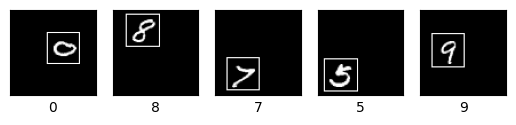

In [ ]:
display_images(training_dataset, 5)

In [ ]:
# class ObjectLocalizationModel(tf.keras.Model):
#   def __init__(self, input_shape=(75, 75, 1), filters=64, kernel=3, units=128, num_classes=10):
#     super(ObjectLocalizationModel, self).__init__()
#     self.conv1 = tf.keras.layers.Conv2D(16, kernel, input_shape=input_shape, activation='relu')
#     self.max_pool = tf.keras.layers.MaxPooling2D((2, 2))
#     self.conv2 = tf.keras.layers.Conv2D((filters-32), kernel, activation='relu')
#     self.conv3 = tf.keras.layers.Conv2D(filters, kernel, activation='relu')
#     self.flatten = tf.keras.layers.Flatten()
#     self.hidden = tf.keras.layers.Dense(units=units, activation='relu')
#     self.classification_out = tf.keras.layers.Dense(units=num_classes, activation='softmax', name="classification")
#     self.box_out = tf.keras.layers.Dense(units=4, activation='relu', name="bounding_box")

#   def call(self, inputs):
#     x = self.conv1(inputs)
#     x = self.max_pool(x)
#     x = self.conv2(x)
#     x = self.max_pool(x)
#     x = self.conv3(x)
#     x = self.max_pool(x)
#     x = self.flatten(x)
#     x = self.hidden(x)
#     classes = self.classification_out(x)
#     bbox = self.box_out(x)
#     return {"classification": classes, "bounding_box": bbox}

In [ ]:
def ObjectLocalizationModel():
  inputs = tf.keras.layers.Input(shape=(75, 75, 1))
  x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(units=128, activation='relu')(x)
  classes = tf.keras.layers.Dense(units=10, activation='softmax', name="classification")(x)
  bbox = tf.keras.layers.Dense(units=4, activation='relu', name="bounding_box")(x)

  model = tf.keras.Model(inputs=inputs, outputs=[classes, bbox])
  return model

In [ ]:
model = ObjectLocalizationModel()
model.compile(
    optimizer="adam",
    loss={
        "classification": "categorical_crossentropy",
        "bounding_box": "mse"
    },
    metrics={
        "classification": "accuracy",
        "bounding_box": "mse"
    }
)

In [ ]:
# model.predict(tf.constant([1], shape=[1, 75, 75, 1], dtype=tf.float32))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 73, 73, 16)           160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 36, 36, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 34, 34, 32)           4640      ['max_pooling2d[0][0]']   

In [ ]:
# Sometimes, having high modularization is not that good :) chore: Need to figure out how to
# viz the model entirely rather than as a object localization model module
# chore completed but not entirely solved, plot_model with class of custom model not done
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
EPOCHS=20
steps_per_epoch = 60000 // BATCH_SIZE
validation_steps = 10000 // BATCH_SIZE
history = model.fit(training_dataset,
          validation_data=validation_dataset,
          epochs=EPOCHS,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps)

Epoch 1/20


2024-01-24 18:52:20.461880: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-24 18:52:20.526670: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-24 18:52:20.768179: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-24 18:52:21.180531: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc869080a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-24 18:52:21.180552: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-01-24 18:52:21.180556: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2024-01-24 18:52:21.184569: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disa

1875/1875 [==============================] - 20s 8ms/step - loss: 0.5844 - classification_loss: 0.5701 - bounding_box_loss: 0.0143 - classification_accuracy: 0.8059 - bounding_box_mse: 0.0143 - val_loss: 0.2046 - val_classification_loss: 0.1980 - val_bounding_box_loss: 0.0066 - val_classification_accuracy: 0.9389 - val_bounding_box_mse: 0.0066
Epoch 2/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1521 - classification_loss: 0.1478 - bounding_box_loss: 0.0043 - classification_accuracy: 0.9545 - bounding_box_mse: 0.0043 - val_loss: 0.0915 - val_classification_loss: 0.0886 - val_bounding_box_loss: 0.0028 - val_classification_accuracy: 0.9718 - val_bounding_box_mse: 0.0028
Epoch 3/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1063 - classification_loss: 0.1040 - bounding_box_loss: 0.0023 - classification_accuracy: 0.9680 - bounding_box_mse: 0.0023 - val_loss: 0.0833 - val_classification_loss: 0.0808 - val_bounding_box_loss: 0.0025 - val_cla

In [ ]:
hist = history.history

In [ ]:
hist.keys()

dict_keys(['loss', 'classification_loss', 'bounding_box_loss', 'classification_accuracy', 'bounding_box_mse', 'val_loss', 'val_classification_loss', 'val_bounding_box_loss', 'val_classification_accuracy', 'val_bounding_box_mse'])

In [ ]:
loss = hist["loss"]
acc = hist["classification_accuracy"]
val_acc = hist["val_classification_accuracy"]
val_loss = hist["val_loss"]
epochs = range(EPOCHS)

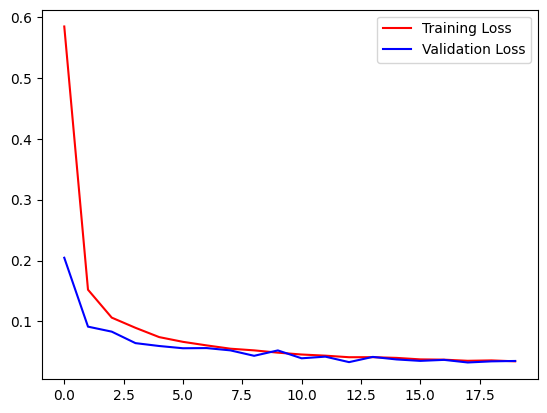

In [ ]:
plt.plot(epochs, loss, color='r', label="Training Loss")
plt.plot(epochs, val_loss, color='b', label="Validation Loss")
plt.legend(loc=0)
plt.show()

1/1 [==============================] - 0s 20ms/step


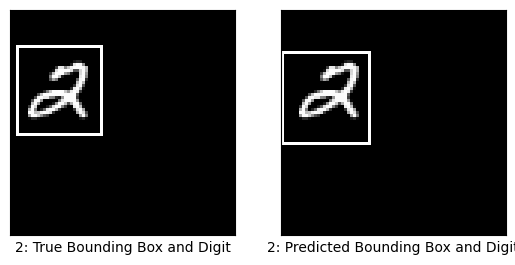

In [ ]:
batch = validation_dataset.take(1)
test_digit = []
test_label = []
test_bbox = []
for example in batch:
    test_digit = example[0].numpy()
    test_label = example[1][0].numpy()
    test_bbox = example[1][1].numpy()
    for digit, label, bbox in zip(test_digit, test_label, test_bbox):
        image, label = draw_bounding_boxes(digit, label, bbox)
        output = model.predict(np.reshape(digit, [1, 75, 75, 1]))
        pred_label = output[0]
        pred_bbox = output[1][0]
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(image)
        axs[0].set_xlabel("{}: True Bounding Box and Digit".format(label))
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        pred_image, pred_label = draw_bounding_boxes(digit, pred_label, pred_bbox)
        axs[1].imshow(pred_image)
        axs[1].set_xlabel("{}: Predicted Bounding Box and Digit".format(label))
        axs[1].set_xticks([])
        axs[1].set_yticks([])
        break

In [ ]:
def intersection_over_union(true_box, pred_box):
  x_min_true, y_min_true, x_max_true, y_max_true = np.split(true_box, 4, axis=1)
  x_min_pred, y_min_pred, x_max_pred, y_max_pred = np.split(pred_box, 4, axis=1)

  x_min_overlap = np.maximum(x_min_true, x_min_pred)
  y_min_overlap = np.minimum(y_min_true, y_min_pred)
  x_max_overlap = np.minimum(x_max_true, x_max_pred)
  y_max_overlap = np.maximum(y_max_true, y_max_pred)

  intersection_area = (np.maximum((x_max_overlap - x_min_overlap), 0) * np.maximum((y_max_overlap - y_min_overlap), 0))
  true_box_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)
  pred_box_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)
  union_area = true_box_area + pred_box_area - intersection_area

  smoothing_factor = 1e-10
  iou = (intersection_area + smoothing_factor) / (union_area + smoothing_factor)

In [ ]:
model.save_weights("./checkpoints/my-checkpoint")